In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import dask.dataframe as dd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Загрузка и просмотр датасета

In [2]:
#Убираем фиктивные колонки, видимо индексы, преобразуем даты чтобы увидеть больше информации из имеющихся данных
df_train = pd.read_csv('data_train.csv')
df_train.drop(columns='Unnamed: 0', inplace=True)
df_train['buy_time'] = pd.to_datetime(df_train['buy_time'], unit='s')
df_test = pd.read_csv('data_test.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test['buy_time'] = pd.to_datetime(df_test['buy_time'], unit='s')
df_train

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-16 21:00:00,0.0
1,1454121,4.0,2018-07-15 21:00:00,0.0
2,2458816,1.0,2018-08-12 21:00:00,0.0
3,3535012,5.0,2018-09-02 21:00:00,0.0
4,1693214,1.0,2018-09-02 21:00:00,0.0
...,...,...,...,...
831648,3812226,2.0,2018-12-30 21:00:00,0.0
831649,2480469,2.0,2018-12-30 21:00:00,0.0
831650,158236,2.0,2018-12-30 21:00:00,0.0
831651,1825525,2.0,2018-12-30 21:00:00,0.0


In [3]:
df_test

,id,vas_id,buy_time
0,3130519,2.0,2019-01-20 21:00:00
1,2000860,4.0,2019-01-20 21:00:00
2,1099444,2.0,2019-01-06 21:00:00
3,1343255,5.0,2019-01-13 21:00:00
4,1277040,2.0,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5.0,2019-01-20 21:00:00
71227,1693213,2.0,2019-01-20 21:00:00
71228,1891350,2.0,2019-01-20 21:00:00
71229,2437172,2.0,2019-01-20 21:00:00


In [4]:
%%time
#Датафрейм очень большой, поэтому решил открывать только n-первых строк от него. В принципе можно еще с пропусками данных пооткрывать. Целиком его не открыть судя по всем на клиентской машине. Процедура та же что и до этого
df_features = pd.read_csv('features.csv.zip', sep='\t',nrows=3000000)
df_features.drop(columns='Unnamed: 0', inplace=True)
df_features['buy_time'] = pd.to_datetime(df_features['buy_time'], unit='s')
df_features

CPU times: total: 3min 31s
Wall time: 3min 34s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 21:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-14 21:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-23 21:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,2018-08-12 21:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,2018-08-05 21:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,3015075,2018-12-16 21:00:00,-62.669971,144.310888,-67.720786,223.873202,-73.138246,202.76821,-10.15618,-53.216097,...,12394.626154,8433.229208,-25.996269,-37.630448,439.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2999996,3015589,2018-09-02 21:00:00,-96.799971,-377.679112,-92.950786,-408.256798,-98.368246,-429.36179,-16.08618,-65.076097,...,-976.373846,-613.770792,-25.996269,-37.630448,-300.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2999997,3016000,2018-08-12 21:00:00,-83.069971,-103.069112,-74.990786,-133.656798,-80.408246,-154.76179,-16.08618,-65.076097,...,-899.373846,-551.770792,-25.996269,-37.630448,-211.747724,-17.832889,1.305572,-6.175933,-0.45614,1.0
2999998,3016127,2018-07-22 21:00:00,-87.639971,-348.219112,-101.580786,-400.826798,-106.998246,-421.93179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### EDA (Explore Data Analysis)

In [5]:
df_features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,...,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,2.181395e+06,1.671841e-02,6.718590e-02,4.080608e-02,9.859992e-02,-1.310689e-02,5.073890e-03,-1.644274e-02,1.198509e-01,-6.622697e-02,...,3.105039e-01,1.237036e-01,1.921284e-01,3.374279e-03,-3.788673e-01,-7.748990e-02,1.638178e-03,-9.938313e-03,2.899782e-03,2.551550e-01
std,1.259158e+06,2.278734e+02,4.402936e+02,2.445470e+02,5.079255e+02,2.592557e+02,5.684854e+02,1.606074e+02,3.217114e+02,8.766180e+01,...,3.207749e+03,2.238185e+03,1.017888e+03,2.982173e+02,1.343382e+03,2.595662e+02,1.546588e+01,1.747745e+02,7.638431e+00,7.732601e-01
min,2.000000e+00,-2.482300e+03,-1.494609e+03,-3.058041e+03,-1.456557e+03,-3.063458e+03,-2.009132e+03,-2.401586e+03,-8.023561e+02,-5.737337e+02,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.067477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
25%,1.091326e+06,-9.679997e+01,-2.095091e+02,-1.107408e+02,-2.431568e+02,-1.161582e+02,-2.603118e+02,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.057477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
50%,2.181240e+06,-8.496997e+01,-6.072911e+01,-8.532079e+01,-7.942680e+01,-8.784825e+01,-9.378179e+01,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.583738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-2.397477e+02,-2.383289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
75%,3.272671e+06,1.191003e+01,1.180709e+02,2.740921e+01,1.258232e+02,2.916175e+01,1.192982e+02,-1.608618e+01,-5.914610e+01,-6.783660e+00,...,-4.853738e+02,-4.077708e+02,-2.499627e+01,-3.363045e+01,-7.774772e+01,-1.083289e+01,-6.944285e-01,-9.175933e+00,-4.561399e-01,1.000000e+00
max,4.362737e+06,2.117307e+05,2.126061e+05,2.117168e+05,2.133577e+05,2.120953e+05,2.137205e+05,2.118114e+05,2.125836e+05,8.852835e+04,...,2.876716e+05,1.904692e+05,9.801580e+05,5.429037e+04,2.715813e+05,9.941817e+04,1.892331e+04,9.750782e+04,9.489544e+03,4.460000e+02


In [15]:
#Смотрим на число уникальный значений признака. Вероятно если одно значание - признак бесполезен, его можно выбросить
#Также видно что у даты 29 уникальный значений, значит все что имеет меньше 30 уникальных значений будем считать за категориальные переменные
df_features.nunique().sort_values()

75           1
81           1
85           1
139          1
203          1
        ...   
117    1697476
207    1776561
38     1865949
116    1994264
id     2933835
Length: 255, dtype: int64

In [7]:
#Смотрю Null. Они отсутствуют везде, значит их не нужно обрабатывать
df_features.isna().sum()

id          0
buy_time    0
0           0
1           0
2           0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 255, dtype: int64

In [8]:
df_train.isna().sum()

id          0
vas_id      0
buy_time    0
target      0
dtype: int64

In [9]:
df_test.isna().sum()

id          0
vas_id      0
buy_time    0
dtype: int64

In [10]:
#Смотрю даты
df_features['buy_time'].unique()

array(['2018-07-15T21:00:00.000000000', '2018-10-14T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-09-23T21:00:00.000000000', '2018-12-09T21:00:00.000000000',
       '2018-09-09T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-11-04T21:00:00.000000000', '2018-09-16T21:00:00.000000000',
       '2018-07-08T21:00:00.000000000', '2018-09-30T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2019-01-13T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000', '2018-11-11T21:00:00.000000000',
       '2018-07-29T21:00:00.000000000', '2019-01-06

In [11]:
#Смотрю время теста, сортируя
test_time = sorted(df_test['buy_time'].unique())
test_time

[numpy.datetime64('2019-01-06T21:00:00.000000000'),
 numpy.datetime64('2019-01-13T21:00:00.000000000'),
 numpy.datetime64('2019-01-20T21:00:00.000000000')]

In [12]:
#Смотрю время трейна, сортируя
#Видно что на трейн, уходит 6 месяцев, а на тест один. Также видно что даты в трейн/тест и у фичей совершенно одинаковые. Это значит что можно мержить фичи в трейн/тест по паре id + дата, т.к пара id и дата полностью описывают параметры пользователей
train_time = sorted(df_train['buy_time'].unique())
train_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [13]:
feature_time = sorted(df_features['buy_time'].unique())
feature_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [16]:
df_train['vas_id'].unique()

array([8., 4., 1., 5., 2., 7., 6., 9.])

In [19]:
#Видно что услуг всего 9, их надо преобразовать в int
df_test['vas_id'].unique()

array([2., 4., 5., 6., 1., 7., 8., 9.])

In [22]:
#Просмотр баланса классов на тесте
X = df_train.drop(columns='target')
target = df_train['target']
X

,id,vas_id,buy_time
0,540968,8.0,2018-09-16 21:00:00
1,1454121,4.0,2018-07-15 21:00:00
2,2458816,1.0,2018-08-12 21:00:00
3,3535012,5.0,2018-09-02 21:00:00
4,1693214,1.0,2018-09-02 21:00:00
...,...,...,...
831648,3812226,2.0,2018-12-30 21:00:00
831649,2480469,2.0,2018-12-30 21:00:00
831650,158236,2.0,2018-12-30 21:00:00
831651,1825525,2.0,2018-12-30 21:00:00


In [23]:
target

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
831648    0.0
831649    0.0
831650    0.0
831651    0.0
831652    0.0
Name: target, Length: 831653, dtype: float64

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

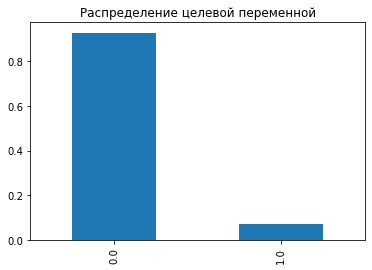

In [25]:
#Очень сильный дизбаланс классов. Возможно во время обучения нужно использовать деревья или мощные ансамбли (LightGBM или CatBoost?)
(target.value_counts()/target.shape[0]).plot(kind='bar', title='Распределение целевой переменной')
target.value_counts()/target.shape

### Итоги EDA, выводы
1. Отсутствуют Null, id уникальны можно поставить индексом в датафреймах
2. Признаки с разными уникальными значениями, там где одно уникальное значение - их можно удалить, они не несут никакого смысла
3. Даты в фичах и в трейн/тест - одинаковые уникальные значения, это хорошо можно сразу мерджить фичи в трейн/тест данные по id + buy_time
4. Сильный дизбаланс классов, линейные модели вряд ли обучатся хорошо. Нужно использовать ансамбли или случайные леса скорее всего.
5. Target, vas_id нужно преобразовать в Int
6. Все признаки у которых уникальные значения в диапазоне от 2 до 30 считаем категориальными на старте
7. При попадании данных в пайплайн постараться делать сразу 3 действия: buy_time преобразовывать в date_time, делать drop 'Unnamed: 0', делать лефт мердж фичи по id и buy_time